#Image classification of Different Building Types Using Pytorch

#Changes and summary

I made some reasearch and came acroos a few things as to why the previous model from the week4 notebook  wasn't performing well and made some change below is a summary of changes made to effect this change:


1.  introducing  Stopping the model early to aviod over fitting
2.   Adding more con2d layers and increased the number of filters .
3. Using dropout to prevent over memorizing
4. Reducing the learning rate
5. Added data augumentation (given the limited number of data we have)





Task: To build a model that classifies Buildings using PyTorch following instructions from a previous notebook

In [1]:
# imorting necessary libraries/Dependencies
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#Part 2: PyTorch

i was having alot of issuses with this part given the fact that it seems i've used up the GPU runtime on google colab 😞 so testing was an issuse but i still made research  on how to use pytorch to solve this classification problem

In [2]:
# import all necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Checking if GPU is present on local machine if not go ahead with CPU to train model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

##Loading the data and adding the data augumentaion

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((400, 300)),       # Resize images to 400x300
    transforms.RandomHorizontalFlip(),   # Data augmentation
    transforms.RandomRotation(10),       # Random rotation
    transforms.ToTensor(),               # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load the dataset from the directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/Building Types/Building Types'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Splitting the dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Max pooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Max pooling
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # Max pooling
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 50 * 37, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Linear(256, 3)                            # Output layer
        )

    def forward(self, x):
        x = self.conv_layer(x)  # Apply convolutional layers
        x = torch.flatten(x, 1) # Flatten the output for the dense layer
        x = self.fc_layer(x)    # Apply fully connected layers
        return x

# Create model instance
model = CNN()


#Training the model

In [6]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00018)

# Training the model
def train_model(num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation accuracy
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Acc: {100 * correct / total:.2f}%')

train_model(10, train_loader, val_loader)


Epoch [1/10], Loss: 0.8126, Validation Acc: 66.25%
Epoch [2/10], Loss: 0.7300, Validation Acc: 70.00%
Epoch [3/10], Loss: 0.6252, Validation Acc: 69.58%
Epoch [4/10], Loss: 0.4620, Validation Acc: 73.33%
Epoch [5/10], Loss: 0.6931, Validation Acc: 71.67%
Epoch [6/10], Loss: 0.4902, Validation Acc: 72.92%
Epoch [7/10], Loss: 0.7191, Validation Acc: 73.75%
Epoch [8/10], Loss: 0.5261, Validation Acc: 68.33%
Epoch [9/10], Loss: 0.3357, Validation Acc: 70.83%
Epoch [10/10], Loss: 0.3575, Validation Acc: 73.75%


#Evaluating the model

In [8]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()  # Assuming using CrossEntropyLoss for a classification task
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Use the function to evaluate the model
test_loss, test_acc = evaluate_model(model, val_loader)
print(f'Test accuracy: {test_acc*100:.2f}%')


Test accuracy: 72.50%


##Saving the model

In [12]:
import torch

# Assuming you have a trained model
torch.save(model, "/content/drive/My Drive/Full_model.pth")

##Loading the model to use

In [13]:
# To load the model
model = torch.load( "/content/drive/My Drive/Full_model.pth")
model.eval()

<ipython-input-13-f21d5f73f625>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load( "/content/drive/My Drive/Full_model.pth")


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=118400, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

#Note/Findings

i realised that the pytourch perform better using the same augumentation  and others

##Function to test model (make_Prediction)


In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.io as tv_io
from PIL import Image


def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)
import torchvision.transforms as transforms



def make_prediction(file_path):
    show_image(file_path)

    # Load image using PIL
    image = Image.open(file_path).convert("RGB")

    # Apply the same transformations as training
    transform = transforms.Compose([
        transforms.Resize((400, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model


    # Perform prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).item()

    print(f"Prediction: {LABELS[prediction]}")


##Actual testing

Prediction: Storey-building


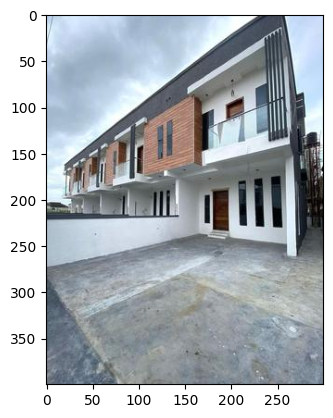

In [23]:
LABELS = ["Bungalow", "High-rise", "Storey-building"]
make_prediction("/content/drive/MyDrive/Colab Notebooks/Building Types/Building Types/Storey-building/81302B3F-5D25-4FED-9232-10A32DECE7C1.jpeg")
